# Trading simulator
In this notebook, this study will replicate the trading strategy based on the training models obtained by the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load hourly price data
prices = pd.read_csv('../../data/hourly_data.csv', index_col=0, parse_dates=True)

# Load the RV data
rv = pd.read_csv('../../results/combined_test_results.csv', index_col=0, parse_dates=True)

# Merge it on Date and Ticker
data = prices.merge(rv, on=['Date', 'Ticker'])

print("Columns")
print(data.columns)
print("Head")
print(data.head())


ERROR! Session/line number was not unique in database. History logging moved to new session 531
Columns
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'ln_hourly_return',
       'hourly_rv', 'ln_hourly_rv', 'ln_hourly_rv_lag1', 'ln_hourly_rv_lag2',
       'ln_hourly_rv_lag3', 'ln_hourly_rv_lag8', 'ln_hourly_rv_lag24', 'Risk',
       'Risk Group', 'Frequency', 'Actual', 'bagging_dt', 'har', 'garch', 'rf',
       'svr', 'ewma'],
      dtype='object')
Head
                                   Open          High           Low  \
Date                                                                  
2024-04-02 01:00:00+00:00  69378.351562  69620.812500  69313.843750   
2024-04-02 02:00:00+00:00  69420.546875  69420.546875  66532.343750   
2024-04-02 03:00:00+00:00  67067.250000  67295.312500  66695.828125   
2024-04-02 04:00:00+00:00  66755.007812  66934.093750  66421.992188   
2024-04-02 05:00:00+00:00  66664.039062  66829.851562  66293.203125   

                                

## Trading portfolio
To simplify this trading portfolio, this paper will consider trading 2 assets over 2 different time period, namely Bitcoin and DOGE during hourly and daily trading periods

In [3]:
# Filter to only read "BTC-USD" and "DOGE-USD"
data = data[data['Ticker'].isin(['BTC-USD', 'DOGE-USD'])]

btc = data[data['Ticker'] == 'BTC-USD'].copy()

btc = btc.sort_index()

btc['return'] = btc['Close'].pct_change()

### Hourly BTC Trading
BTC is considered a low-risk coin, and it will use the GARCH model to implement the trades

#### Trading signals
A trading signal is used for entry or exit. If forecast < signal: buy (Signal = 1). In this basic example, the signal shall be the median

In [4]:
btc['garch_expanding_median'] = btc['garch'].rolling(window=72).median().shift(1)
btc['ewma_expanding_median']  = btc['ewma'].rolling(window=72).median().shift(1)
btc['rv_ma'] = btc['hourly_rv'].rolling(window=72).median().shift(1)

# Generate signals: long (1) if today's forecast is below the historical median (indicating lower volatility), else 0.
btc['signal_garch'] = np.where(btc['garch'] < btc['garch_expanding_median'], 1, 0)
btc['signal_ewma']  = np.where(btc['ewma']  < btc['ewma_expanding_median'], 1, 0)
btc['signal_rv_ma'] = np.where(btc['hourly_rv'] < btc['rv_ma'], 1, 0)
 

#### Strategy Returns
Lag the signal by one-hour --> Use one-hour ago's signal for today's return

In [5]:
btc['strategy_return_garch'] = btc['signal_garch'].shift(1) * btc['return']
btc['strategy_return_ewma'] = btc['signal_ewma'].shift(1) * btc['return']
btc['strategy_return_rv_ma'] = btc['signal_rv_ma'].shift(1) * btc['return']


#### Cumulative Return
Obtain 3 cumulative returns, with the last one being the buy and hold strategy

In [6]:
btc['cum_return_garch'] = (1 + btc['strategy_return_garch'].fillna(0)).cumprod() - 1
btc['cum_return_ewma'] = (1 + btc['strategy_return_ewma'].fillna(0)).cumprod() - 1
btc['cum_return_hold'] = (1 + btc['return'].fillna(0)).cumprod() - 1 
btc['cum_return_rv_ma'] = (1 + btc['strategy_return_rv_ma'].fillna(0)).cumprod() - 1



#### True Trading Strategy
Now assume that we begin with USD $10,000 initial capital

In [7]:
initial_capital = 10000

btc['portfolio_value_garch'] = initial_capital * (1 + btc['cum_return_garch'])
btc['portfolio_value_ewma']  = initial_capital * (1 + btc['cum_return_ewma'])
btc['portfolio_value_hold']  = initial_capital * (1 + btc['cum_return_hold'])
btc['portfolio_value_rv_ma'] = initial_capital * (1 + btc['cum_return_rv_ma'])


##### PNL

In [8]:
btc['PnL_garch'] = btc['portfolio_value_garch'] - initial_capital
btc['PnL_ewma']  = btc['portfolio_value_ewma']  - initial_capital
btc['PnL_hold']  = btc['portfolio_value_hold']  - initial_capital
btc['PnL_rv_ma'] = btc['portfolio_value_rv_ma'] - initial_capital


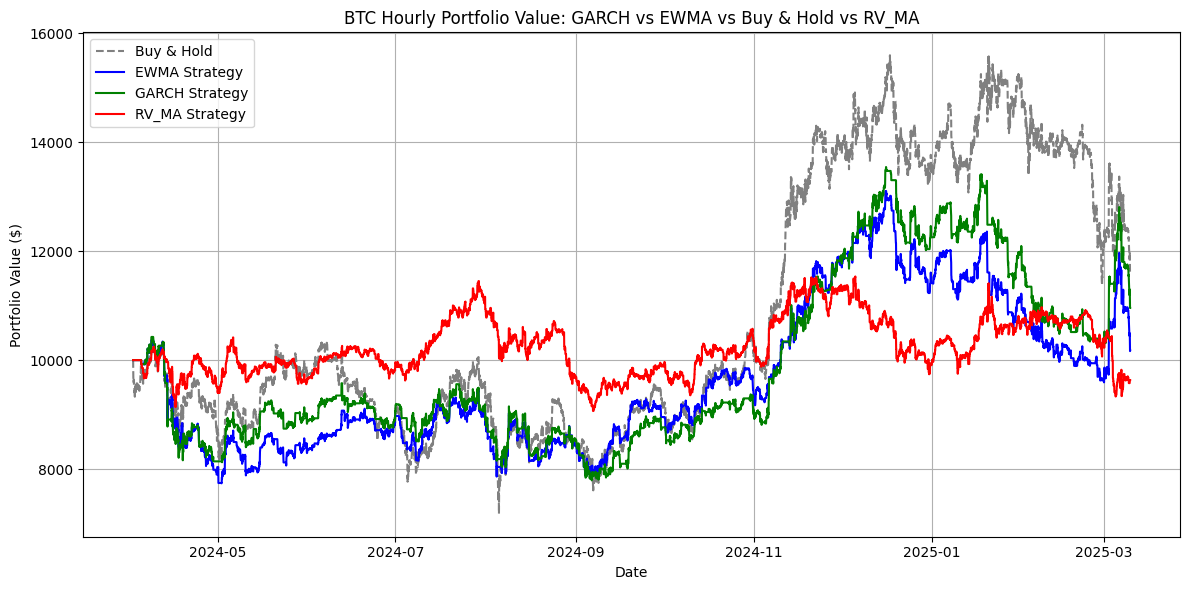

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(btc.index, btc['portfolio_value_hold'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(btc.index, btc['portfolio_value_ewma'], label='EWMA Strategy', color='blue')
plt.plot(btc.index, btc['portfolio_value_garch'], label='GARCH Strategy', color='green')
plt.plot(btc.index, btc['portfolio_value_rv_ma'], label='RV_MA Strategy', color='red')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('BTC Hourly Portfolio Value: GARCH vs EWMA vs Buy & Hold vs RV_MA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Final PNL

In [10]:
final_value_garch = btc['portfolio_value_garch'].iloc[-1]
final_value_ewma  = btc['portfolio_value_ewma'].iloc[-1]
final_value_hold  = btc['portfolio_value_hold'].iloc[-1]
final_value_rv_ma = btc['portfolio_value_rv_ma'].iloc[-1]

print("Final Portfolio Value (GARCH Strategy): ${:.2f}".format(final_value_garch))
print("Final Portfolio Value (EWMA Strategy):  ${:.2f}".format(final_value_ewma))
print("Final Portfolio Value (Buy & Hold):     ${:.2f}".format(final_value_hold))
print("Final Portfolio Value (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma))

print("\nFinal PnL (GARCH Strategy): ${:.2f}".format(final_value_garch - initial_capital))
print("Final PnL (EWMA Strategy):  ${:.2f}".format(final_value_ewma - initial_capital))
print("Final PnL (Buy & Hold):     ${:.2f}".format(final_value_hold - initial_capital))
print("Final PnL (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma - initial_capital))


Final Portfolio Value (GARCH Strategy): $10956.46
Final Portfolio Value (EWMA Strategy):  $10176.92
Final Portfolio Value (Buy & Hold):     $11617.77
Final Portfolio Value (RV_MA Strategy):  $9634.28

Final PnL (GARCH Strategy): $956.46
Final PnL (EWMA Strategy):  $176.92
Final PnL (Buy & Hold):     $1617.77
Final PnL (RV_MA Strategy):  $-365.72


### 3 Hourly Data
Now we will examine the three hourly trading strategy. For all three hourly risk classification, EWMA performed the best. We will compare it with the second best trading strategy for medium-risk coin, which is the GARCH method. The medium risk coin identified is the XRP coin

In [11]:
data = pd.read_csv('../../data/three_hourly_data.csv', index_col=0, parse_dates=True)
rv = pd.read_csv('../../results/combined_test_results.csv', parse_dates=True)

# Ensure both Date columns are datetime with UTC timezone
data['Date'] = pd.to_datetime(data['Date']).dt.tz_convert('UTC')
rv['Date'] = pd.to_datetime(rv['Date']).dt.tz_convert('UTC')

# Now merge on Date and Ticker using an inner join
merged_data = pd.merge(data, rv, on=['Date', 'Ticker'], how='inner')

xrp = merged_data[merged_data['Ticker'] == 'XRP-USD'].copy()
xrp['return'] = xrp['Close'].pct_change()
xrp = xrp.sort_index()

C:\Users\young\AppData\Local\Temp\ipykernel_17092\3766406076.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('../../data/three_hourly_data.csv', index_col=0, parse_dates=True)


#### Trading signals
A trading signal is used for entry or exit. If forecast < signal: buy (Signal = 1). In this basic example, the signal shall be the median

In [12]:
xrp['garch_expanding_median'] = xrp['garch'].rolling(window=24).median().shift(1)
xrp['ewma_expanding_median']  = xrp['ewma'].rolling(window=24).median().shift(1)
xrp['rv_ma'] = xrp['3_hourly_rv'].rolling(window=24).median().shift(1)

# Generate signals: long (1) if today's forecast is below the historical median (indicating lower volatility), else 0.
xrp['signal_garch'] = np.where(xrp['garch'] < xrp['garch_expanding_median'], 1, 0)
xrp['signal_ewma']  = np.where(xrp['ewma']  < xrp['ewma_expanding_median'], 1, 0)
xrp['signal_rv_ma'] = np.where(xrp['3_hourly_rv'] < xrp['rv_ma'], 1, 0)


#### Strategy Returns
Lag the signal by one-hour --> Use one-hour ago's signal for today's return

In [13]:
xrp['strategy_return_garch'] = xrp['signal_garch'].shift(1) * xrp['return']
xrp['strategy_return_ewma'] = xrp['signal_ewma'].shift(1) * xrp['return']
xrp['strategy_return_rv_ma'] =xrp['signal_rv_ma'].shift(1) * xrp['return']


#### Cumulative Return
Obtain 3 cumulative returns, with the last one being the buy and hold strategy

In [14]:
xrp['cum_return_garch'] = (1 + xrp['strategy_return_garch'].fillna(0)).cumprod() - 1
xrp['cum_return_ewma'] = (1 + xrp['strategy_return_ewma'].fillna(0)).cumprod() - 1
xrp['cum_return_hold'] = (1 + xrp['return'].fillna(0)).cumprod() - 1 
xrp['cum_return_rv_ma'] = (1 + xrp['strategy_return_rv_ma'].fillna(0)).cumprod() - 1



#### True Trading Strategy
Now assume that we begin with USD $10,000 initial capital

In [15]:
initial_capital = 10000

xrp['portfolio_value_garch'] = initial_capital * (1 + xrp['cum_return_garch'])
xrp['portfolio_value_ewma']  = initial_capital * (1 + xrp['cum_return_ewma'])
xrp['portfolio_value_hold']  = initial_capital * (1 + xrp['cum_return_hold'])
xrp['portfolio_value_rv_ma'] = initial_capital * (1 + xrp['cum_return_rv_ma'])


##### PNL

In [16]:
xrp['PnL_garch'] = xrp['portfolio_value_garch'] - initial_capital
xrp['PnL_ewma']  = xrp['portfolio_value_ewma']  - initial_capital
xrp['PnL_hold']  = xrp['portfolio_value_hold']  - initial_capital
xrp['PnL_rv_ma'] = xrp['portfolio_value_rv_ma'] - initial_capital


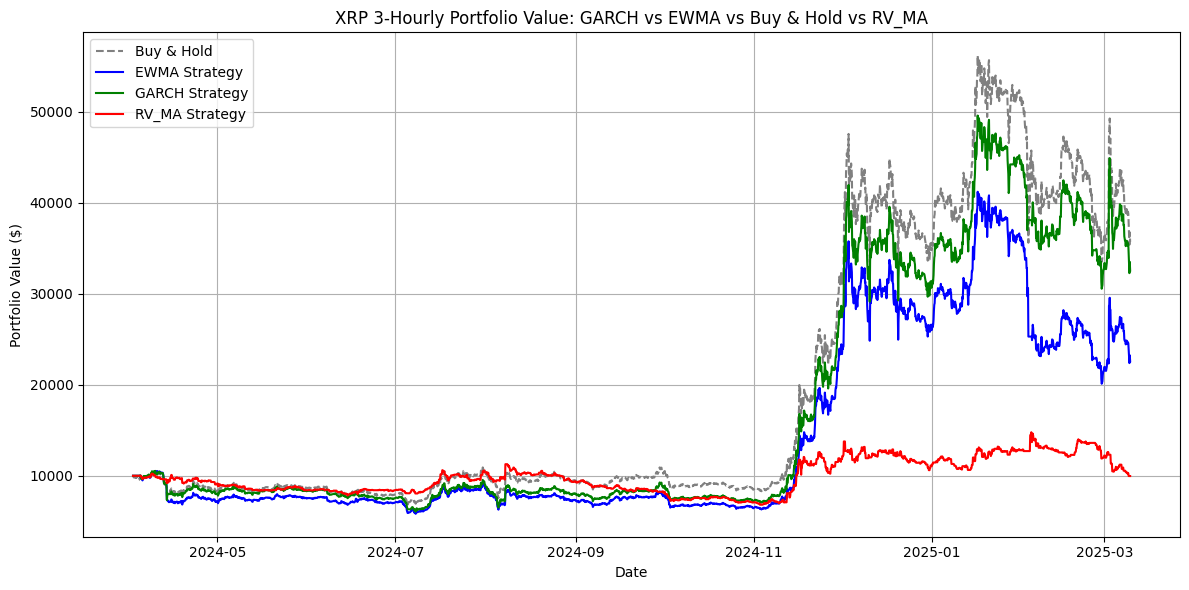

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(xrp['Date'], xrp['portfolio_value_hold'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(xrp['Date'], xrp['portfolio_value_ewma'], label='EWMA Strategy', color='blue')
plt.plot(xrp['Date'], xrp['portfolio_value_garch'], label='GARCH Strategy', color='green')
plt.plot(xrp['Date'], xrp['portfolio_value_rv_ma'], label='RV_MA Strategy', color='red')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('XRP 3-Hourly Portfolio Value: GARCH vs EWMA vs Buy & Hold vs RV_MA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Final PNL

In [18]:
final_value_garch = xrp['portfolio_value_garch'].iloc[-1]
final_value_ewma  = xrp['portfolio_value_ewma'].iloc[-1]
final_value_hold  = xrp['portfolio_value_hold'].iloc[-1]
final_value_rv_ma = xrp['portfolio_value_rv_ma'].iloc[-1]

print("Final Portfolio Value (GARCH Strategy): ${:.2f}".format(final_value_garch))
print("Final Portfolio Value (EWMA Strategy):  ${:.2f}".format(final_value_ewma))
print("Final Portfolio Value (Buy & Hold):     ${:.2f}".format(final_value_hold))
print("Final Portfolio Value (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma))

print("\nFinal PnL (GARCH Strategy): ${:.2f}".format(final_value_garch - initial_capital))
print("Final PnL (EWMA Strategy):  ${:.2f}".format(final_value_ewma - initial_capital))
print("Final PnL (Buy & Hold):     ${:.2f}".format(final_value_hold - initial_capital))
print("Final PnL (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma - initial_capital))


Final Portfolio Value (GARCH Strategy): $32542.04
Final Portfolio Value (EWMA Strategy):  $22577.15
Final Portfolio Value (Buy & Hold):     $35696.33
Final Portfolio Value (RV_MA Strategy):  $9974.02

Final PnL (GARCH Strategy): $22542.04
Final PnL (EWMA Strategy):  $12577.15
Final PnL (Buy & Hold):     $25696.33
Final PnL (RV_MA Strategy):  $-25.98


### Daily Trading
Lastly, we will examine a high-risk coin that engages in daily trading. In this case, the high-risk coin selected will be the DOGE coin. For high risk and daily trading, SVR proved to be the most effective

In [19]:
data = pd.read_csv('../../data/daily_data.csv', index_col=0, parse_dates=True)
rv = pd.read_csv('../../results/combined_test_results.csv', parse_dates=True)

# Ensure both Date columns are datetime with UTC timezone
data['Date'] = pd.to_datetime(data['Date']).dt.tz_convert('UTC')
rv['Date'] = pd.to_datetime(rv['Date']).dt.tz_convert('UTC')

# Now merge on Date and Ticker using an inner join
merged_data = pd.merge(data, rv, on=['Date', 'Ticker'], how='inner')

svr = merged_data[merged_data['Ticker'] == 'DOGE-USD'].copy()
svr['return'] = svr['Close'].pct_change()
svr = svr.sort_index()

svr

C:\Users\young\AppData\Local\Temp\ipykernel_17092\2907864900.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('../../data/daily_data.csv', index_col=0, parse_dates=True)


,Date,Ticker,Open,High,Low,Close,Volume,daily_rv,ln_daily_rv,daily_return,...,Risk Group,Frequency,Actual,bagging_dt,har,garch,rf,svr,ewma,return
998,2024-04-03 00:00:00+00:00,DOGE-USD,0.175547,0.176407,0.175332,0.175647,0.0,0.006337,-5.061406,-0.036694,...,high,hourly,-6.914622,-10.641561,-10.613355,-9.462454,-10.765855,-10.191507,-9.130486,NaN
999,2024-04-04 00:00:00+00:00,DOGE-USD,0.178015,0.179955,0.178015,0.179910,0.0,0.002147,-6.143861,0.024271,...,high,hourly,-8.425274,-9.911299,-11.632077,-10.107792,-10.109554,-9.275184,-8.728403,0.024271
1000,2024-04-05 00:00:00+00:00,DOGE-USD,0.177580,0.178228,0.177424,0.177539,0.0,0.001861,-6.286567,-0.013181,...,high,3hourly,-7.845413,-8.786211,-8.917364,-7.920436,-8.696533,-8.652198,-8.017964,-0.013181
1001,2024-04-05 00:00:00+00:00,DOGE-USD,0.177580,0.178228,0.177424,0.177539,0.0,0.001861,-6.286567,-0.013181,...,high,hourly,-12.162970,-11.090861,-12.275954,-10.281229,-10.949733,-10.880466,-9.676716,0.000000
1002,2024-04-06 00:00:00+00:00,DOGE-USD,0.186475,0.187552,0.185580,0.185935,44450176.0,0.001236,-6.696262,0.047293,...,high,3hourly,-8.973790,-8.747266,-8.498183,-8.387997,-8.743864,-8.651245,-8.307718,0.047293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,2025-03-08 00:00:00+00:00,DOGE-USD,0.192741,0.192977,0.191705,0.192178,0.0,0.000794,-7.137938,-0.029251,...,high,daily,-7.137938,-5.872391,-5.843906,-6.176154,-5.929160,-5.622626,-6.001612,0.000000
1992,2025-03-08 00:00:00+00:00,DOGE-USD,0.192741,0.192977,0.191705,0.192178,0.0,0.000794,-7.137938,-0.029251,...,high,hourly,-9.236675,-10.866894,-11.319766,-9.964541,-11.024177,-10.505984,-8.409670,0.000000
1993,2025-03-09 00:00:00+00:00,DOGE-USD,0.167006,0.168468,0.166369,0.167850,62752256.0,0.003753,-5.585129,-0.126591,...,high,3hourly,-8.496401,-9.355036,-9.117101,-8.645356,-9.361184,-9.080402,-8.809138,-0.126591
1994,2025-03-09 00:00:00+00:00,DOGE-USD,0.167006,0.168468,0.166369,0.167850,62752256.0,0.003753,-5.585129,-0.126591,...,high,daily,-5.585129,-5.309314,-5.587086,-6.191490,-5.350708,-5.378912,-5.917389,0.000000


#### Trading signals
A trading signal is used for entry or exit. If forecast < signal: buy (Signal = 1). In this basic example, the signal shall be the median

In [20]:
svr['svr_expanding_median'] = svr['svr'].rolling(window=3).median().shift(1)
svr['ewma_expanding_median']  = svr['ewma'].rolling(window=3).median().shift(1)
svr['rv_ma'] = svr['daily_rv'].rolling(window=3).median().shift(1)

# Generate signals: long (1) if today's forecast is below the historical median (indicating lower volatility), else 0.
svr['signal_svr'] = np.where(svr['svr'] < svr['svr_expanding_median'], 1, 0)
svr['signal_ewma']  = np.where(svr['ewma']  < svr['ewma_expanding_median'], 1, 0)
svr['signal_rv_ma'] = np.where(svr['daily_rv'] < svr['rv_ma'], 1, 0)


#### Strategy Returns
Lag the signal by one-hour --> Use one-hour ago's signal for today's return

In [21]:
svr['strategy_return_svr'] = svr['signal_svr'].shift(1) * svr['return']
svr['strategy_return_ewma'] = svr['signal_ewma'].shift(1) * svr['return']
svr['strategy_return_rv_ma'] =svr['signal_rv_ma'].shift(1) * svr['return']


#### Cumulative Return
Obtain 3 cumulative returns, with the last one being the buy and hold strategy

In [22]:
svr['cum_return_svr'] = (1 + svr['strategy_return_svr'].fillna(0)).cumprod() - 1
svr['cum_return_ewma'] = (1 + svr['strategy_return_ewma'].fillna(0)).cumprod() - 1
svr['cum_return_hold'] = (1 + svr['return'].fillna(0)).cumprod() - 1 
svr['cum_return_rv_ma'] = (1 + svr['strategy_return_rv_ma'].fillna(0)).cumprod() - 1



#### True Trading Strategy
Now assume that we begin with USD $10,000 initial capital

In [23]:
initial_capital = 10000

svr['portfolio_value_svr'] = initial_capital * (1 + svr['cum_return_svr'])
svr['portfolio_value_ewma']  = initial_capital * (1 + svr['cum_return_ewma'])
svr['portfolio_value_hold']  = initial_capital * (1 + svr['cum_return_hold'])
svr['portfolio_value_rv_ma'] = initial_capital * (1 + svr['cum_return_rv_ma'])


##### PNL

In [24]:
svr['PnL_garch'] = svr['portfolio_value_svr'] - initial_capital
svr['PnL_ewma']  = svr['portfolio_value_ewma']  - initial_capital
svr['PnL_hold']  = svr['portfolio_value_hold']  - initial_capital
svr['PnL_rv_ma'] = svr['portfolio_value_rv_ma'] - initial_capital


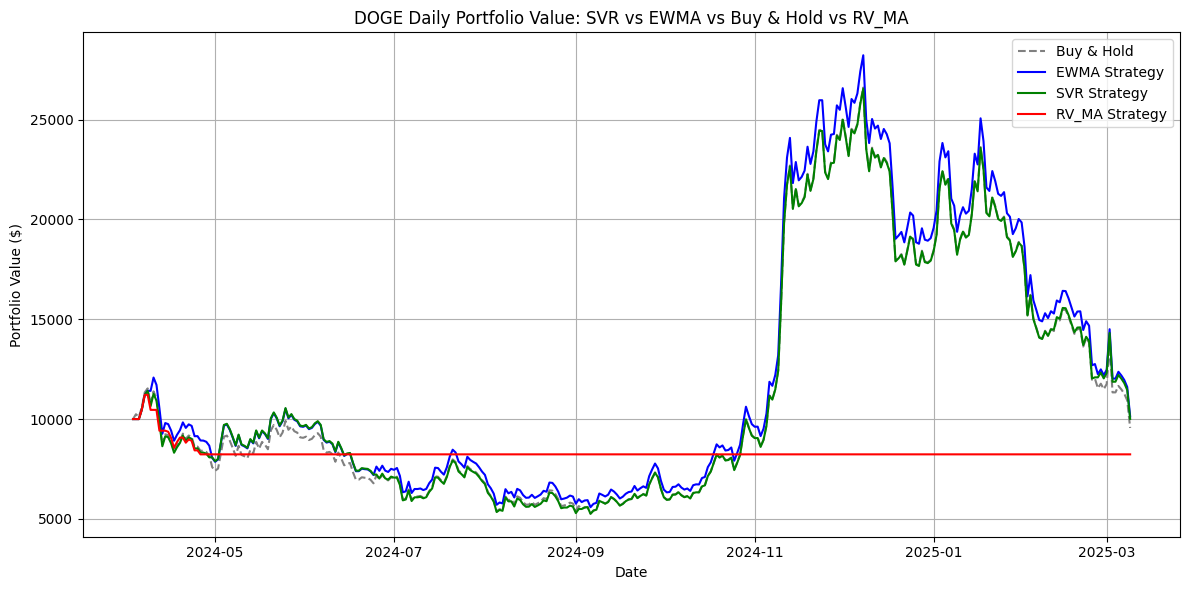

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(svr['Date'], svr['portfolio_value_hold'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(svr['Date'], svr['portfolio_value_ewma'], label='EWMA Strategy', color='blue')
plt.plot(svr['Date'], svr['portfolio_value_svr'], label='SVR Strategy', color='green')
plt.plot(svr['Date'], svr['portfolio_value_rv_ma'], label='RV_MA Strategy', color='red')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('DOGE Daily Portfolio Value: SVR vs EWMA vs Buy & Hold vs RV_MA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Final PNL

In [26]:
final_value_garch = svr['portfolio_value_svr'].iloc[-1]
final_value_ewma  = svr['portfolio_value_ewma'].iloc[-1]
final_value_hold  = svr['portfolio_value_hold'].iloc[-1]
final_value_rv_ma = svr['portfolio_value_rv_ma'].iloc[-1]

print("Final Portfolio Value (GARCH Strategy): ${:.2f}".format(final_value_garch))
print("Final Portfolio Value (EWMA Strategy):  ${:.2f}".format(final_value_ewma))
print("Final Portfolio Value (Buy & Hold):     ${:.2f}".format(final_value_hold))
print("Final Portfolio Value (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma))

print("\nFinal PnL (SVR Strategy): ${:.2f}".format(final_value_garch - initial_capital))
print("Final PnL (EWMA Strategy):  ${:.2f}".format(final_value_ewma - initial_capital))
print("Final PnL (Buy & Hold):     ${:.2f}".format(final_value_hold - initial_capital))
print("Final PnL (RV_MA Strategy):  ${:.2f}".format(final_value_rv_ma - initial_capital))


Final Portfolio Value (GARCH Strategy): $10006.19
Final Portfolio Value (EWMA Strategy):  $10137.51
Final Portfolio Value (Buy & Hold):     $9556.10
Final Portfolio Value (RV_MA Strategy):  $8232.70

Final PnL (SVR Strategy): $6.19
Final PnL (EWMA Strategy):  $137.51
Final PnL (Buy & Hold):     $-443.90
Final PnL (RV_MA Strategy):  $-1767.30
